In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import lightgbm as lgb

from functools import reduce

In [101]:
test=pd.read_csv("data/test.csv",parse_dates=["dt"])
train=pd.read_csv("data/train.csv",parse_dates=["dt"])
price_df = pd.concat([train, test]).sort_values("dt").reset_index(drop=True)
gruz=pd.read_csv("data/Грузоперевозки.csv",parse_dates=["dt"])
rynok_stroy=pd.read_csv("data/Данные рынка стройматериалов.csv",parse_dates=["dt"])
lme=pd.read_csv("data/Индекс LME.csv",parse_dates=["дата"])
# macro=pd.read_csv("data/Макропоказатели.csv",parse_dates=["dt"])# большое количество пропусков, нестабильные показатели
rynok_metal=pd.read_csv("data/Показатели рынка металла.csv",parse_dates=["dt"])
fuel=pd.read_csv("data/Топливо.csv",parse_dates=["dt"])
raw=pd.read_csv("data/Цены на сырье.csv",parse_dates=["dt"])
# chmf=pd.read_csv("data/CHMF Акции.csv",parse_dates=["dt"])#
# magn=pd.read_csv("data/MAGN Акции.csv",parse_dates=["dt"])# нестабильные показатели, который мало будет влиять на целевую переменную
# nlmk=pd.read_csv("data/NLMK Акции.csv",parse_dates=["dt"])#

In [102]:
print("||||||||||||||||||||||||||||||||||||||||||||||||||")
price_df.info()
print("|||||||||||||||||||||||||Грузоперевозки|||||||||||||||||||||||||")
gruz.info()
print("|||||||||||||||||||||||||Данные рынка стройматериалов|||||||||||||||||||||||||")
rynok_stroy.info()
print("|||||||||||||||||||||||||Индекс LME|||||||||||||||||||||||||")
lme.info()
# print("|||||||||||||||||||||||||Макропоказатели|||||||||||||||||||||||||")
# macro.info()
print("|||||||||||||||||||||||||Показатели рынка металла|||||||||||||||||||||||||")
rynok_metal.info()
print("|||||||||||||||||||||||||Топливо|||||||||||||||||||||||||")
fuel.info()
print("|||||||||||||||||||||||||Цены на сырье|||||||||||||||||||||||||")
raw.info()
# print("|||||||||||||||||||||||||CHMF Акции|||||||||||||||||||||||||")
# chmf.info()
# print("|||||||||||||||||||||||||MAGN Акции|||||||||||||||||||||||||")
# magn.info()
# print("|||||||||||||||||||||||||NLMK Акции|||||||||||||||||||||||||")
# nlmk.info()

||||||||||||||||||||||||||||||||||||||||||||||||||
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                428 non-null    datetime64[ns]
 1   Цена на арматуру  428 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.8 KB
|||||||||||||||||||||||||Грузоперевозки|||||||||||||||||||||||||
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   dt                               302 non-null    datetime64[ns]
 1   Индекс стоимости грузоперевозок  302 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.8 KB
|||||||||||||||||||||||||Данные рынка стройматериалов|||||||||||||||||

In [103]:
dfs=[
     price_df,
     gruz,
     rynok_stroy,
     lme,
     # macro,
     rynok_metal,
     fuel,
     raw,
     # chmf,
     # magn,
     # nlmk
     ]
for df in dfs:
    df.rename(columns=lambda x:"dt"if x.lower()in["date", "дата"]else x,inplace=True)
    df["dt"]=pd.to_datetime(df["dt"])

конец ▼

In [104]:
for i,dataframe in enumerate(dfs):
    dataframe["dt"]=pd.to_datetime(dataframe["dt"],format="%Y-%m-%d")# форматирование в один вид дат
    dfs[i]=dataframe.set_index("dt").resample("W-MON").mean().reset_index()# всё к понедельникам, как цена
df_extended=reduce(lambda left,right:pd.merge(left,right,on="dt",how="left"),dfs)# соединение по цене
df_extended

,dt,Цена на арматуру,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-01-05,32900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-12,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-19,32000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-26,30700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-02-02,30300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2023-02-13,44500.0,1322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22765.0,457.5,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
424,2023-02-20,46000.0,1330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23414.0,465.0,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
425,2023-02-27,49200.0,1343.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24014.0,455.0,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0
426,2023-03-06,53700.0,1372.0,127.55719,56.7124,1395.32091,323.144673,4.104,194.063078,62.10118,...,24005.0,467.5,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0


<Axes: >

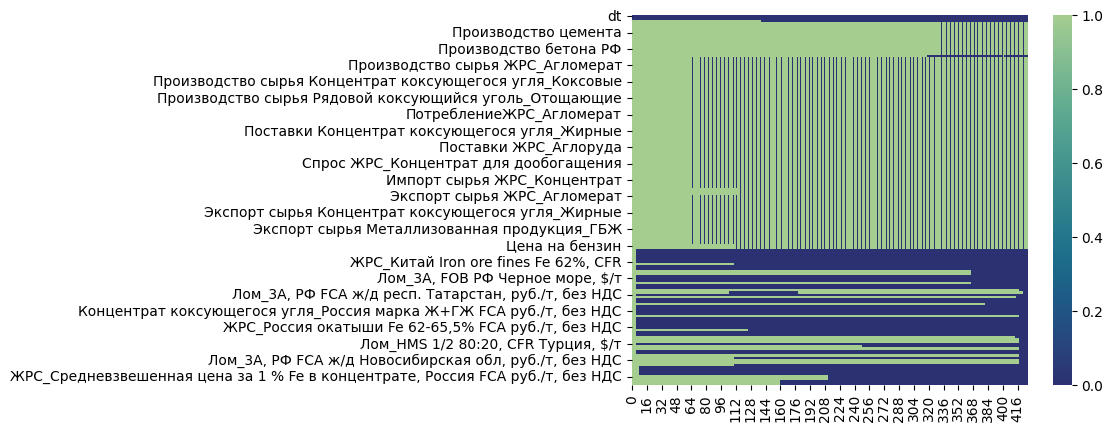

In [105]:
sb.heatmap(df_extended.isnull().T,cmap="crest_r")

In [106]:
def drop_columns_with_nan(df, threshold_percent):
  nan_percentages=df.isnull().mean()*100
  columns_to_drop=nan_percentages[nan_percentages>threshold_percent].index.tolist()
  print(f"{len(columns_to_drop)} колонок с NaN больше {threshold_percent}%")
  return columns_to_drop
threshold=50
columns_to_drop=drop_columns_with_nan(df_extended, threshold)
df_extended=df_extended.drop(columns=columns_to_drop)
# интерполяция, bfill и ffil
df_extended=df_extended.interpolate(method='linear').fillna(method='bfill')# заполнение назад
df_extended=df_extended.interpolate(method='linear').fillna(method='ffill')# заполнение вперёд

113 колонок с NaN больше 50%


C:\Users\mesnevi\AppData\Local\Temp\ipykernel_25648\3749147692.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_extended=df_extended.interpolate(method='linear').fillna(method='bfill')# заполнение назад
C:\Users\mesnevi\AppData\Local\Temp\ipykernel_25648\3749147692.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_extended=df_extended.interpolate(method='linear').fillna(method='ffill')# заполнение вперёд


<Axes: >

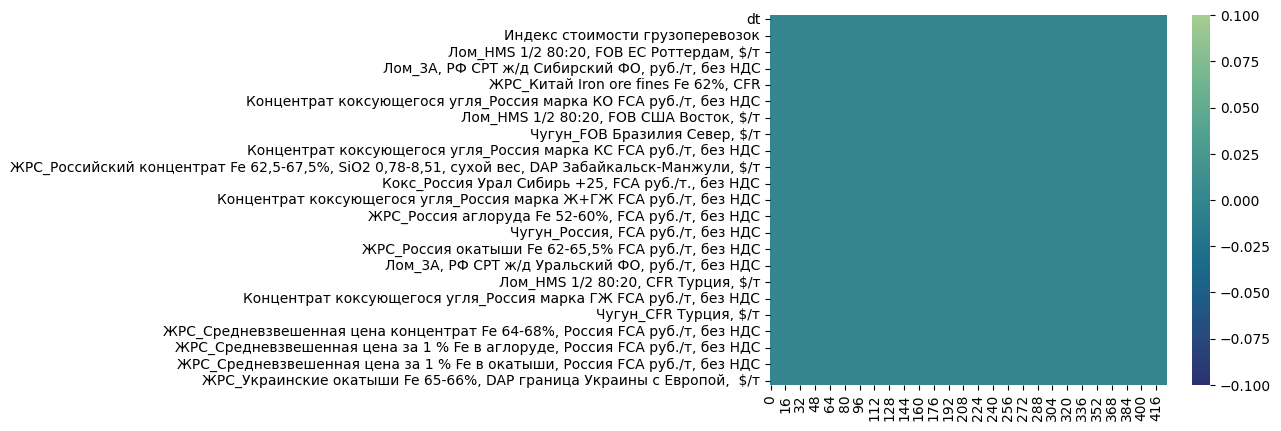

In [107]:
sb.heatmap(df_extended.isnull().T,cmap="crest_r")

In [108]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 45 columns):
 #   Column                                                                                            Non-Null Count  Dtype         
---  ------                                                                                            --------------  -----         
 0   dt                                                                                                428 non-null    datetime64[ns]
 1   Цена на арматуру                                                                                  428 non-null    float64       
 2   Индекс стоимости грузоперевозок                                                                   428 non-null    float64       
 3   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  428 non-null    float64       
 4   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                              

In [109]:
df_extended.set_index("dt", inplace=True)# реиндексим и данные из даты
df_extended["year"]=df_extended.index.year      # год
df_extended["month"]=df_extended.index.month    # месяц
df_extended["day"]=df_extended.index.day        # день
df_extended["quarter"]=df_extended.index.quarter# квартал

In [ ]:
df_extended.to_csv("data/to-modal.csv",index=True)# сохраняем

Выбор между ▲ и ▼

In [ ]:
merged_df=dfs[0]
for df in dfs[1:]:
    merged_df=pd.merge(merged_df,df,on="dt",how="left")
merged_df.info(verbose=True)

In [ ]:
plt.figure(figsize=(5,5))
sb.heatmap(merged_df.transpose().isnull(), cbar=False)
plt.show()

In [ ]:
clanky_df=merged_df.copy()
clanky_df.dropna(thresh=len(clanky_df)*.4,axis=1,inplace=True)
plt.figure(figsize=(5,5))
sb.heatmap(clanky_df.transpose().isnull(), cbar=False)
plt.show()
clanky_df.info()

In [ ]:
def polate(column):
    non_missing_indices = column.notna()
    x = np.arange(len(column))[non_missing_indices]
    y = column[non_missing_indices]

    coefficients = np.polyfit(x, y, 2)
    poly = np.poly1d(coefficients)

    missing_indices = np.arange(len(column))[~non_missing_indices]
    predicted_values = poly(missing_indices)

    column[missing_indices]=predicted_values
    return column
clanky_df=clanky_df.apply(polate,axis=0)
plt.figure(figsize=(5,5))
sb.heatmap(clanky_df.transpose().isnull(), cbar=False)
plt.show()

конец ▲

<Axes: xlabel='дата', ylabel='цена'>

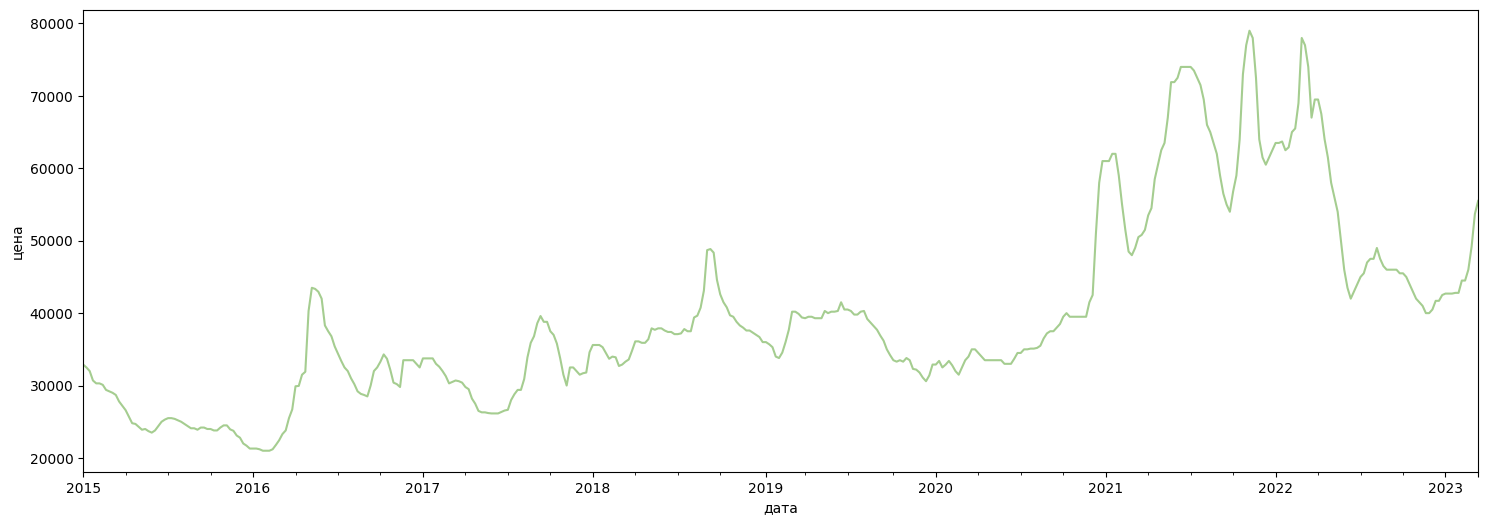

In [111]:
df_extended['Цена на арматуру'].plot(figsize=(18,6),title=None,colormap="crest",xlabel="дата",ylabel="цена")

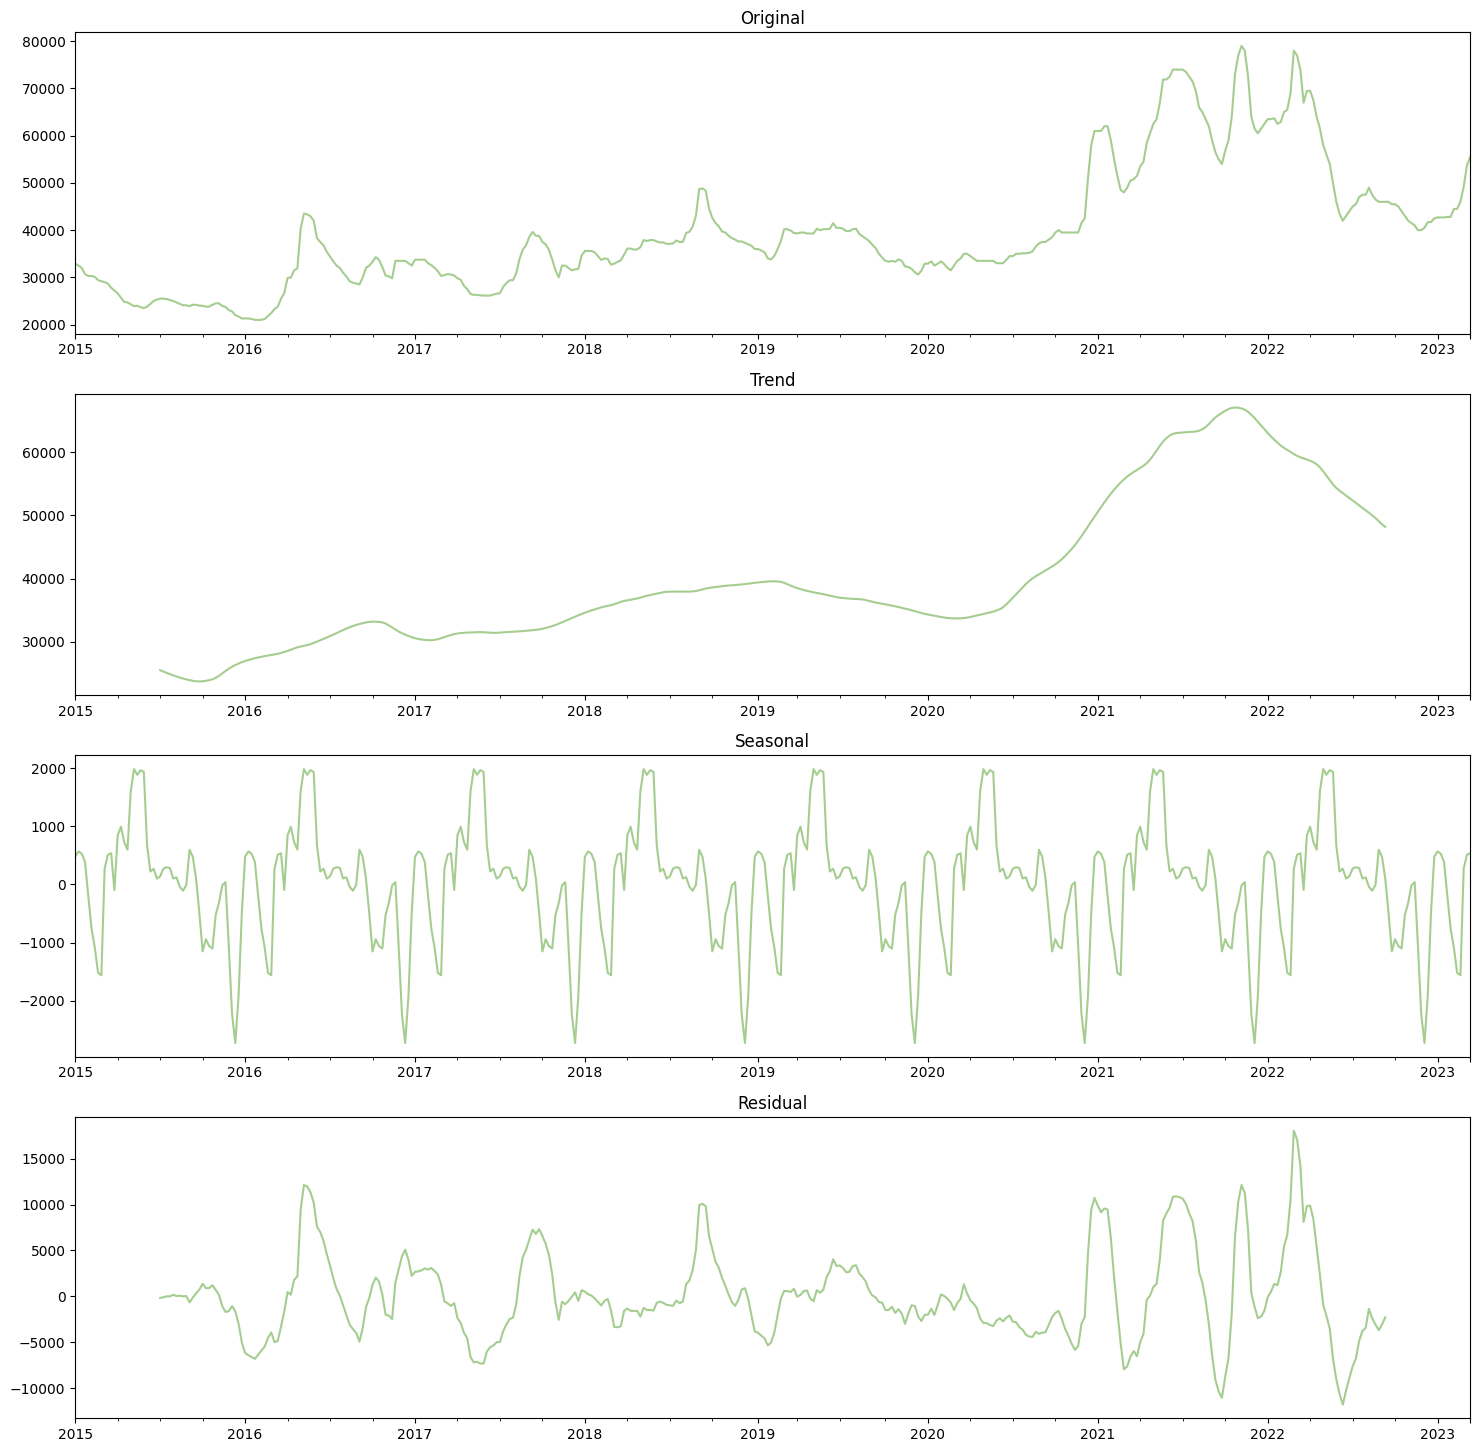

In [ ]:
fig,ax=plt.subplots(nrows=4,ncols=1,figsize=(18,18))
decompose=seasonal_decompose(df_extended[["Цена на арматуру"]])

ax[0].set_title("Original")
ax[1].set_title("Trend")
ax[2].set_title("Seasonal")
ax[3].set_title("Residual")

decompose.observed.plot(ax=ax[0],colormap="crest")
decompose.trend.plot(ax=ax[1],colormap="crest")
decompose.seasonal.plot(ax=ax[2],colormap="crest")
decompose.resid.plot(ax=ax[3],colormap="crest")

for a in ax:
    a.set_xlabel(None)

In [113]:
def check_stationary(column):
    p_value=adfuller(column)[1]
    print(f"p={round(p_value,4)}",end=", ")
    if p_value>0.05:print("Ряд нестационарен")
    else:print("Ряд стационарен")
check_stationary(df_extended["Цена на арматуру"])

p=0.3292, Ряд нестационарен


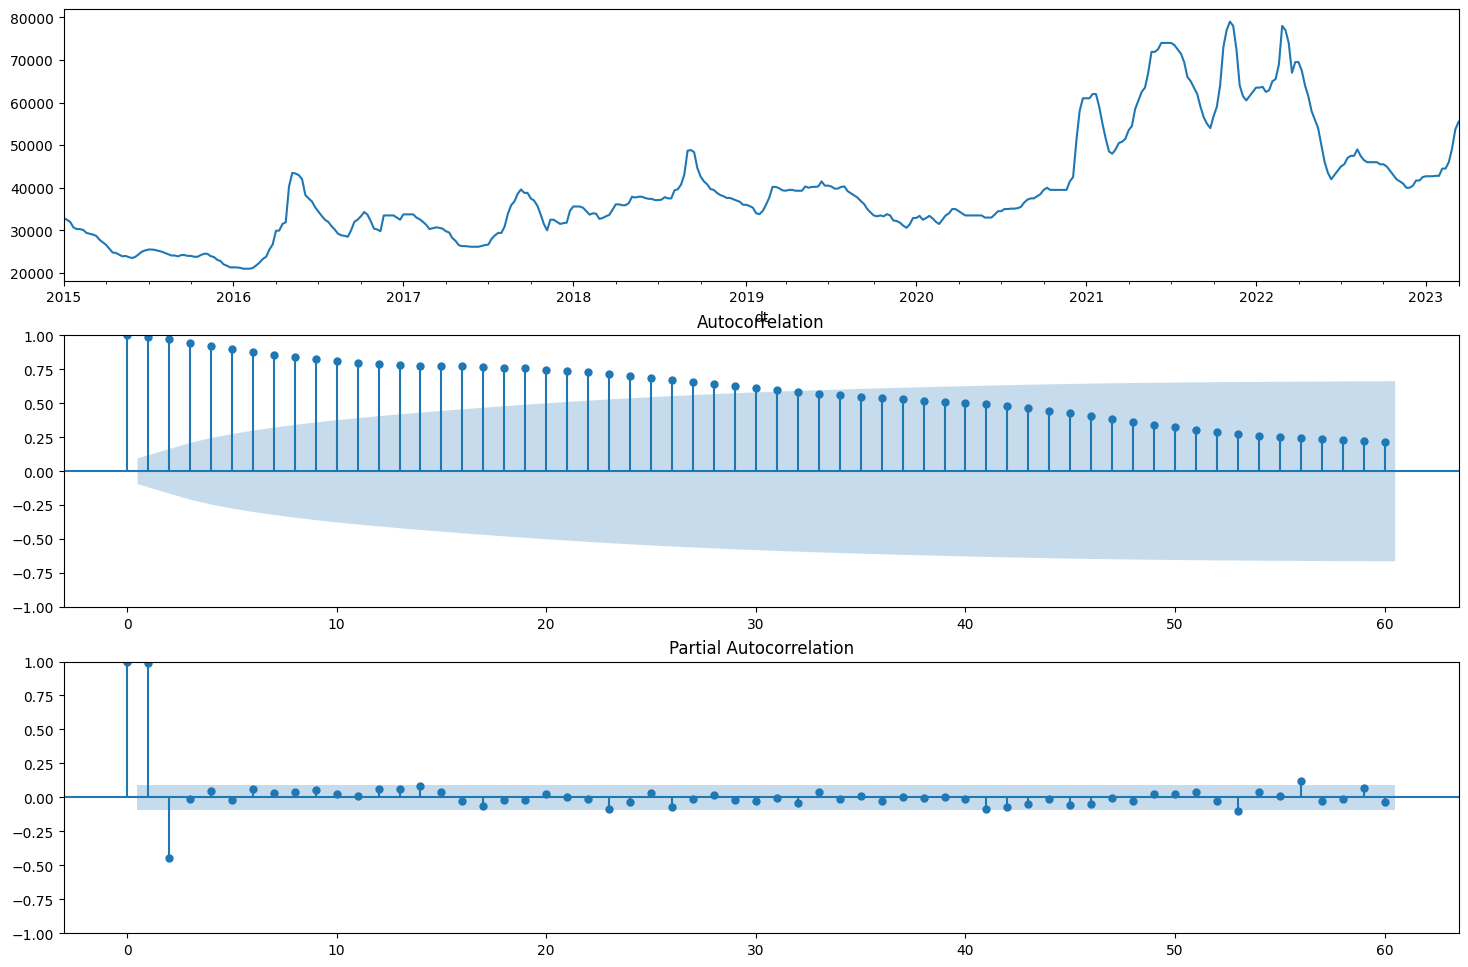

In [114]:
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(18,12))
df_extended["Цена на арматуру"].plot(ax=ax[0])
plot_acf(df_extended["Цена на арматуру"],lags=60,ax=ax[1])
plot_pacf(df_extended["Цена на арматуру"],lags=60,ax=ax[2]);